# 14-6. 프로젝트 : 폐렴 진단기 성능개선


좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.



# Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [2]:
# 라이브러리 import
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [3]:
# 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj47/aiffel


# Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [4]:
# 2. 데이터 가져오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

# 이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 갯수는 달라질 수 있습니다.
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1114
Pneumonia images count in training set: 3071


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없습니다.

In [7]:
# tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
print('ok')

ok


In [8]:
# train, validation 데이터셋 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [9]:
# 라벨 이름 확인 
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [10]:
# 현재 이미지에는 라벨 데이터가 따로 없습니다. 
# 제목에 'NORMAL', 'PNEUMONIA'라고 되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [11]:
# 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
# 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
# decode_img 함수와 process_path 함수를 만들겠습니다.
# process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. 
# get_label을 이용해서 라벨 값을 가져옵니다.

def decode_img(img):
    # 이미지를 uint8 tensor로 변경
    img = tf.image.decode_jpeg(img, channels=3)
    
    # img를 범위 [0,1]에서 float32 데이터 타입으로 바꾼다
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # img의 이미지 사이즈를IMAGE_SIZE에서 지정한 사이즈로 수정한다.
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줍니다.

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print('ok')

ok


In [13]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.
for image, label in train_ds.take(1): 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
# 테스트 데이터셋 작성 및 데이터 갯수 확인

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
# 만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

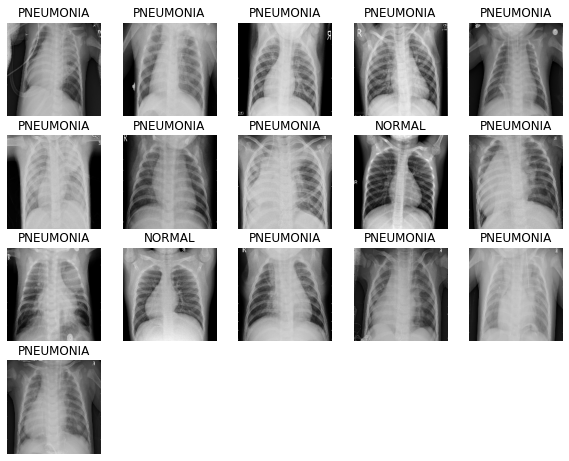

In [16]:
image_batch, label_batch = next(iter(train_ds)) 
# https://dojang.io/mod/page/view.php?id=2408 확인해볼것 next, iter 관련

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [19]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

# Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [21]:
# batchnormalization, dropout 둘다 사용

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
# batchnormalization만 사용

def dense_block2(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(), 
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [28]:
# dropuout만 사용

def dense_block3(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [29]:
# dropuout만 rate 조절 사용

def dense_block4(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [25]:
# Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# denseblock2 batchnomalization만 사용

In [30]:
# Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

def build_model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block2(512, 0.7),
        dense_block2(128, 0.5),
        dense_block2(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# denseblock2 dropout만 사용

In [31]:
# Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

def build_model3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block3(512, 0.7),
        dense_block3(128, 0.5),
        dense_block3(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
# denseblock4 dropout 비율 조정

In [32]:
# Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

def build_model4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block4(512, 0.9),
        dense_block4(128, 0.7),
        dense_block4(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [33]:

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1} # 처리 생략해서 해보기

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.88
Weight for class 1: 0.68


# classweight 처리 생략해보기

In [ ]:

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight1 = {0: weight_for_0, 1: weight_for_1} # 처리 생략해서 해보기

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
# recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과는?

# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [42]:
# optimizer나 leraning rate 변경 고려

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# bulid_model2

In [38]:
# b
# optimizer나 leraning rate 변경 고려

with tf.device('/GPU:0'):
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# bulid_model3

In [39]:

# optimizer나 leraning rate 변경 고려

with tf.device('/GPU:0'):
    model3 = build_model3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# bulid_model4

In [41]:

# optimizer나 leraning rate 변경 고려

with tf.device('/GPU:0'):
    model4 = build_model4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [43]:
# model fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, # 생략해서 해보기
    )

Epoch 1/25
261/261 [==============================] - 30s 114ms/step - loss: 0.4439 - accuracy: 0.7704 - precision: 0.9301 - recall: 0.7429 - val_loss: 0.5892 - val_accuracy: 0.7740 - val_precision: 0.7740 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 91ms/step - loss: 0.2593 - accuracy: 0.8937 - precision: 0.9702 - recall: 0.8821 - val_loss: 0.9893 - val_accuracy: 0.7750 - val_precision: 0.7750 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 92ms/step - loss: 0.2164 - accuracy: 0.9188 - precision: 0.9706 - recall: 0.9171 - val_loss: 0.1702 - val_accuracy: 0.9356 - val_precision: 0.9253 - val_recall: 0.9975
Epoch 4/25
261/261 [==============================] - 24s 93ms/step - loss: 0.1821 - accuracy: 0.9318 - precision: 0.9744 - recall: 0.9314 - val_loss: 0.6523 - val_accuracy: 0.7808 - val_precision: 1.0000 - val_recall: 0.7168
Epoch 5/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1843 - accuracy: 

# Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

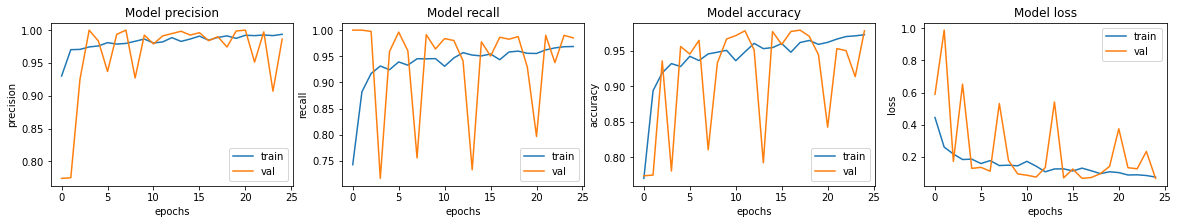

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
# 모델 평가를 위해 loss, acc, precision, recall 값 출력
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 62ms/step - loss: 1.1254 - accuracy: 0.7516 - precision: 0.7196 - recall: 0.9872


In [46]:
# model fit
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, # 생략해서 해보기
    )

Epoch 1/25
261/261 [==============================] - 25s 97ms/step - loss: 0.2618 - accuracy: 0.8930 - precision: 0.9695 - recall: 0.8819 - val_loss: 0.6112 - val_accuracy: 0.7769 - val_precision: 0.7769 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1811 - accuracy: 0.9306 - precision: 0.9796 - recall: 0.9246 - val_loss: 0.7561 - val_accuracy: 0.7769 - val_precision: 0.7769 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1516 - accuracy: 0.9423 - precision: 0.9822 - recall: 0.9383 - val_loss: 0.4918 - val_accuracy: 0.8202 - val_precision: 0.8119 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1441 - accuracy: 0.9456 - precision: 0.9813 - recall: 0.9438 - val_loss: 0.2559 - val_accuracy: 0.8990 - val_precision: 0.9972 - val_recall: 0.8725
Epoch 5/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1339 - accuracy: 0

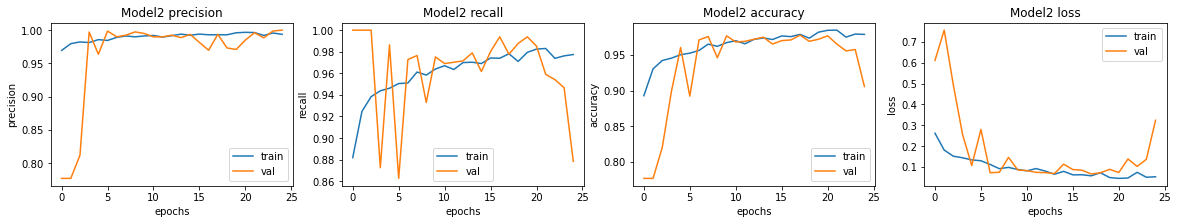

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model2 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
# 모델 평가를 위해 loss, acc, precision, recall 값 출력
loss, acc, prec, rec = model2.evaluate(test_ds)

39/39 [==============================] - 3s 65ms/step - loss: 0.5580 - accuracy: 0.8798 - precision: 0.8741 - recall: 0.9436


In [49]:
# model fit
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, # 생략해서 해보기
    )

Epoch 1/25
261/261 [==============================] - 26s 100ms/step - loss: 0.3655 - accuracy: 0.8302 - precision: 0.9286 - recall: 0.8326 - val_loss: 0.6276 - val_accuracy: 0.7750 - val_precision: 0.7750 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 26s 98ms/step - loss: 0.2215 - accuracy: 0.9064 - precision: 0.9789 - recall: 0.8917 - val_loss: 1.5897 - val_accuracy: 0.7750 - val_precision: 0.7750 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 25s 97ms/step - loss: 0.2115 - accuracy: 0.9157 - precision: 0.9789 - recall: 0.9049 - val_loss: 0.2556 - val_accuracy: 0.9183 - val_precision: 0.9196 - val_recall: 0.9801
Epoch 4/25
261/261 [==============================] - 25s 98ms/step - loss: 0.1922 - accuracy: 0.9219 - precision: 0.9830 - recall: 0.9091 - val_loss: 2.1648 - val_accuracy: 0.2221 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1574 - ac

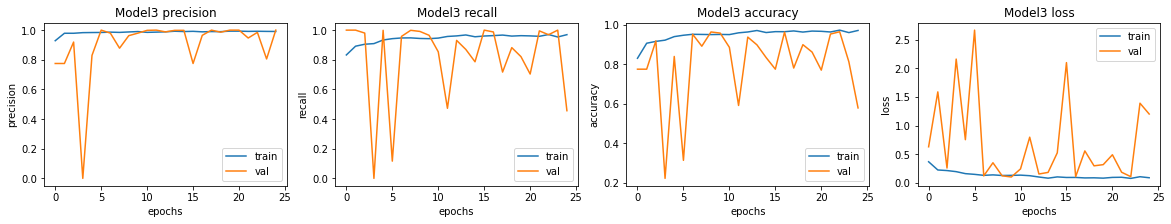

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model3 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
# 모델 평가를 위해 loss, acc, precision, recall 값 출력
loss, acc, prec, rec = model3.evaluate(test_ds)

39/39 [==============================] - 2s 63ms/step - loss: 0.7078 - accuracy: 0.7083 - precision: 0.9444 - recall: 0.5667


In [52]:
# model fit
with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, # 생략해서 해보기
    )

Epoch 1/25
261/261 [==============================] - 26s 99ms/step - loss: 0.5943 - accuracy: 0.7021 - precision: 0.8846 - recall: 0.6831 - val_loss: 0.5828 - val_accuracy: 0.7740 - val_precision: 0.7740 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 25s 98ms/step - loss: 0.3102 - accuracy: 0.8748 - precision: 0.9598 - recall: 0.8655 - val_loss: 1.2743 - val_accuracy: 0.7750 - val_precision: 0.7750 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 26s 100ms/step - loss: 0.2800 - accuracy: 0.8918 - precision: 0.9583 - recall: 0.8914 - val_loss: 0.1523 - val_accuracy: 0.9471 - val_precision: 0.9688 - val_recall: 0.9628
Epoch 4/25
261/261 [==============================] - 26s 100ms/step - loss: 0.2401 - accuracy: 0.9107 - precision: 0.9696 - recall: 0.9067 - val_loss: 0.1365 - val_accuracy: 0.9471 - val_precision: 0.9412 - val_recall: 0.9938
Epoch 5/25
261/261 [==============================] - 26s 98ms/step - loss: 0.2026 - accuracy:

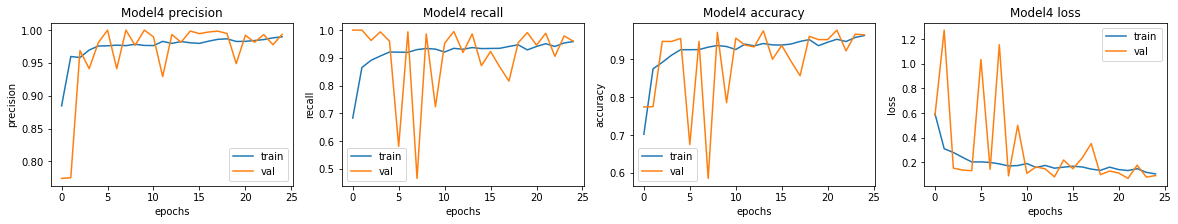

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model4 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [54]:
# 모델 평가를 위해 loss, acc, precision, recall 값 출력
loss, acc, prec, rec = model4.evaluate(test_ds)

39/39 [==============================] - 2s 63ms/step - loss: 0.5075 - accuracy: 0.8317 - precision: 0.8000 - recall: 0.9744


1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
Accuracy 기준 85%에 도달하였다.

# 총평

먼저 노드에서 하라는대로 사진을 반전 시키는 것을 적용해봤다. 기존 노드와 비교해보니 좌우반전이 적용된 사진을 확인할 수 있었다.  
내가 제대로 적용한 것인지는 모르겠지만 노드에서 나온대로 모델에서 BatchNormalization과 Dropout 사용 유무, Dropout 비율?을 조정하여 다양한 모델을 실행해봤다.  
내가 돌린 모델에서는 batchnormalization만 사용한? 모델이 accuracy가 0.87로 가장 높은 결과를 얻었다.  
결과 그래프를 보면 다른 모델들은 val결과가 위아래로 튀는 값이 많이 보이는데 batchnorm을 사용한 model2의 그래프가 train과 val이 가장 유사한 것을 볼 수 있다. 다른 분들은 그냥 돌렸을 때도 넘었다고 하던데... 나는 batchnorm만 사용한 것이 가장 높게 나왔다.  
아직도 노드 진행하면서 이게 맞는건지 틀린건지 감..?이 안잡혀서 큰일이다 ㅠㅠ